In [130]:
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train, fit_rocket, fit_classifier
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

eeg_data_1 = pd.read_csv('data/subject1/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject1/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject1/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject1/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject1/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject1/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [131]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated


### z-normalization

In [132]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [133]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [134]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

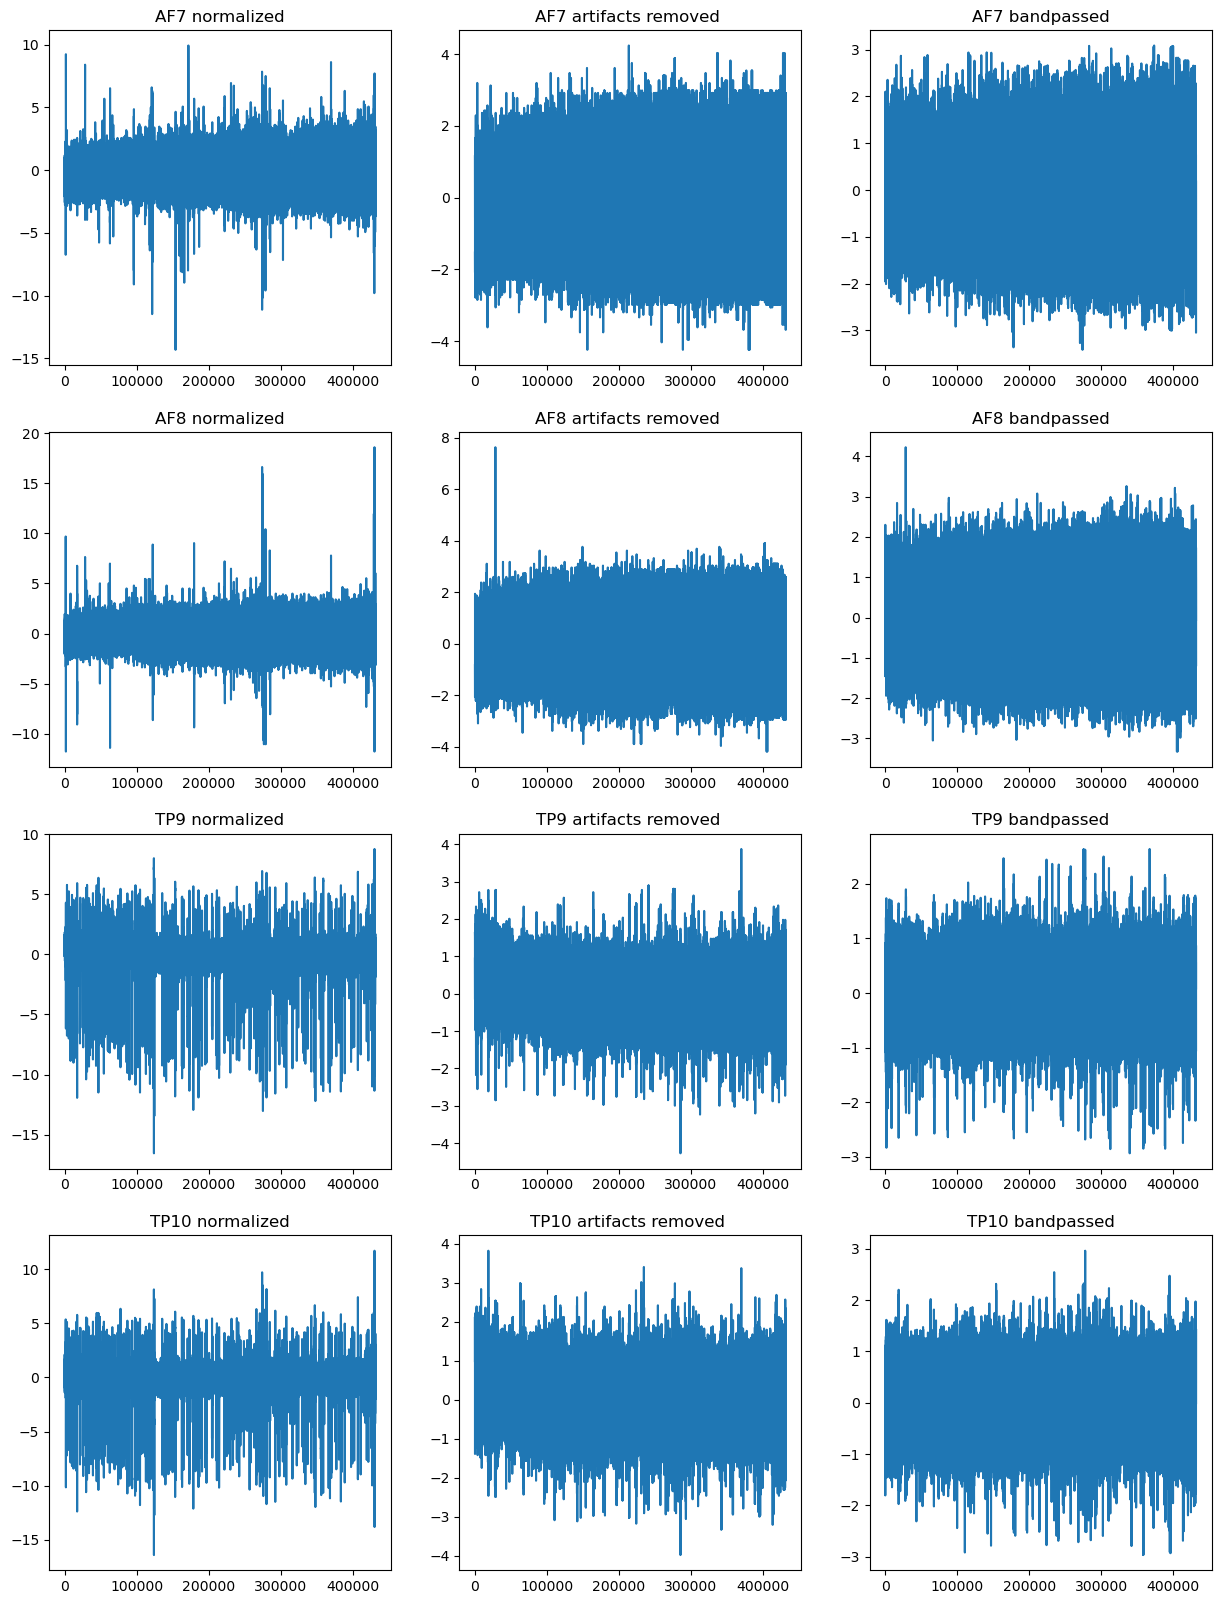

In [135]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Separate trials

In [136]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Time differences in trials

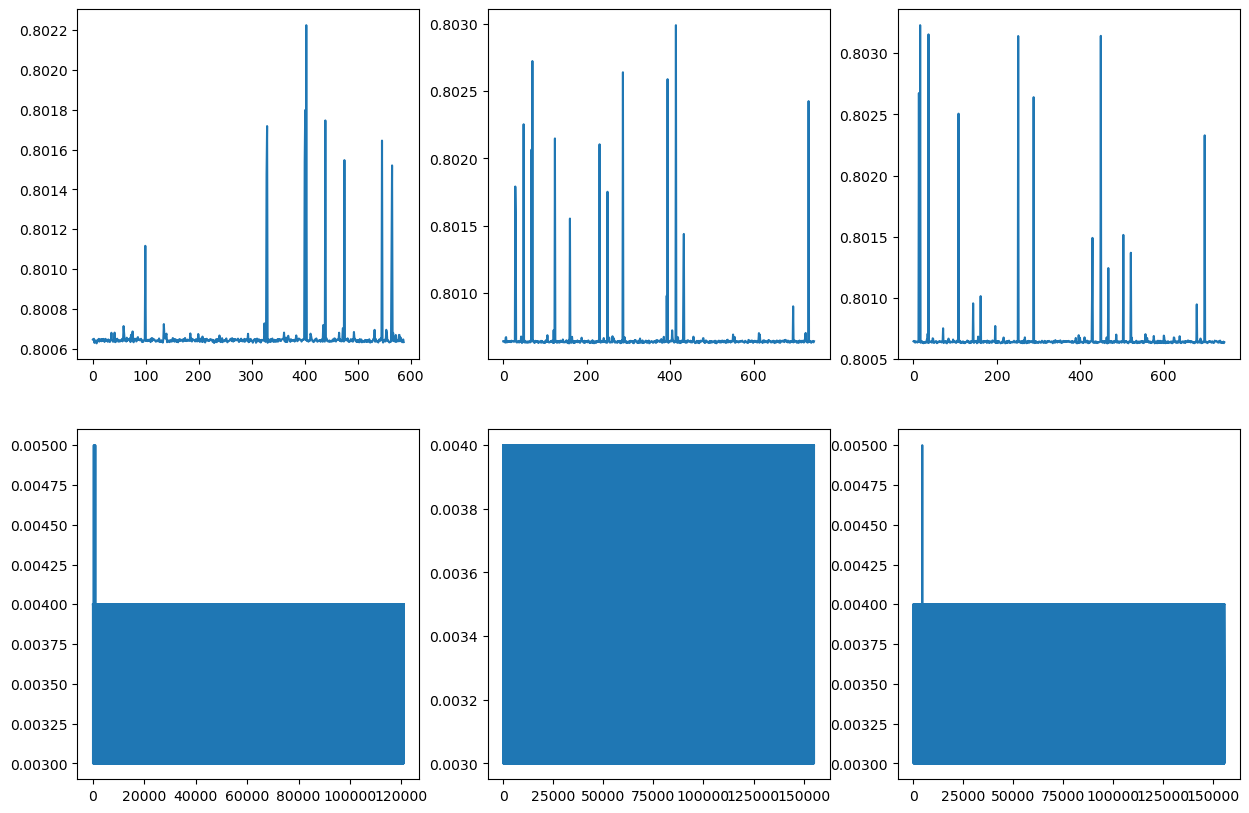

In [137]:
eeg_trials = [eeg_data_t1, eeg_data_t2, eeg_data_t3]
gradcpt_trials = [gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3]
plot_sample_durations(eeg_trials, gradcpt_trials)

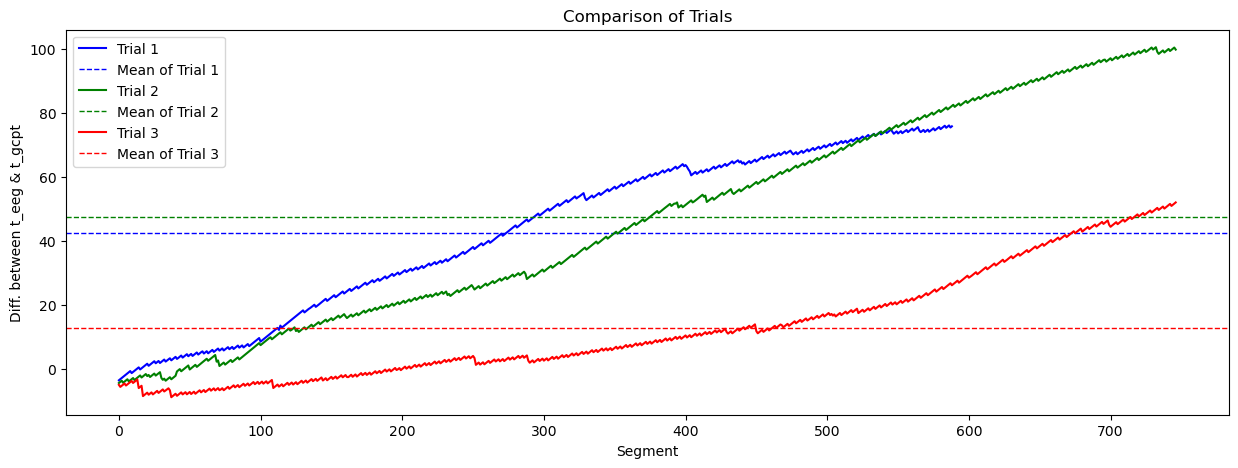

In [138]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### Segment

In [139]:
combined_eeg_df = pd.concat([eeg_data_t1, eeg_data_t2, eeg_data_t3], ignore_index=True)
combined_gradcpt_df = pd.concat([gradcpt_data_t1, gradcpt_data_t2, gradcpt_data_t3], ignore_index=True)

In [140]:
all_channel_segments = []

# Process each channel
for channel in channels:
    # Segment the current EEG data for the channel
    channel_segments = segment_column(combined_eeg_df[f'{channel}_bandpassed'], combined_gradcpt_df)
    
    # Convert the list of segments into a numpy array with shape (number of segments, 205)
    # Not introducing the singleton dimension this time
    channel_segments_array = np.array(channel_segments).reshape(-1, 205)
    
    # Append the reshaped segments for this channel to the list
    all_channel_segments.append(channel_segments_array)

# Stack the channel segments along a new axis to combine them
# This should result in a shape: (number of segments, number of channels, 205)
combined_segments = np.stack(all_channel_segments, axis=1)
labels = np.array(combined_gradcpt_df['in_the_zone'])

print(f"Corrected combined segments shape: {combined_segments.shape}")
print(f"Labels shape: {labels.shape}")

Corrected combined segments shape: (2083, 4, 205)
Labels shape: (2083,)


## Sequential Feature detachmend

### Combined features

In [163]:
X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_af7, X_test_af7 = X_train[:,0:1,:], X_test[:,0:1,:]
X_train_af8, X_test_af8 = X_train[:,1:2,:], X_test[:,1:2,:]
X_train_tp9, X_test_tp9 = X_train[:,2:3,:], X_test[:,2:3,:]
X_train_tp10, X_test_tp10 = X_train[:,3:4,:], X_test[:,3:4,:]

In [181]:
model_combined_features = fit_rocket(X_train, X_test, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 59.21%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 43.00
Train Accuraccy Detach Model: 89.15%
-------------------------
Test Accuraccy Full Model: 57.83%
Test Accuraccy Detach-ROCKET: 56.23%
-------------------------
Optimal Model Size: 11.01% of full model


In [182]:
X_train_transformed = model_combined_features.transform_features(X_train)
X_test_transformed = model_combined_features.transform_features(X_test)

In [183]:
fit_classifier(X_train_transformed, X_test_transformed, y_train, y_test);

training acc:  0.6915254237288135
testing acc:  0.5910543130990416


### Separate channels

### AF7

In [184]:
model_af7 = fit_rocket(X_train_af7, X_test_af7, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 70.28%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 134.00
Train Accuraccy Detach Model: 56.61%
-------------------------
Test Accuraccy Full Model: 59.74%
Test Accuraccy Detach-ROCKET: 56.87%
-------------------------
Optimal Model Size: 0.07% of full model


In [185]:
X_train_transformed_af7 = model_af7.transform_features(X_train_af7)
X_test_transformed_af7 = model_af7.transform_features(X_test_af7)

In [186]:
fit_classifier(X_train_transformed_af7, X_test_transformed_af7, y_train, y_test);

training acc:  0.5717514124293785
testing acc:  0.5623003194888179


### AF8

In [187]:
model_af8 = fit_rocket(X_train_af8, X_test_af8, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 68.08%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 114.00
Train Accuraccy Detach Model: 58.36%
-------------------------
Test Accuraccy Full Model: 57.19%
Test Accuraccy Detach-ROCKET: 50.48%
-------------------------
Optimal Model Size: 0.28% of full model


In [188]:
X_train_transformed_af8 = model_af8.transform_features(X_train_af8)
X_test_transformed_af8 = model_af8.transform_features(X_test_af8)

In [189]:
fit_classifier(X_train_transformed_af8, X_test_transformed_af8, y_train, y_test);

training acc:  0.5649717514124294
testing acc:  0.5303514376996805


### TP9

In [190]:
model_tp9 = fit_rocket(X_train_tp9, X_test_tp9, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 6951927.96
Train Accuraccy Full ROCKET: 55.31%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 90.00
Train Accuraccy Detach Model: 58.53%
-------------------------
Test Accuraccy Full Model: 53.99%
Test Accuraccy Detach-ROCKET: 48.24%
-------------------------
Optimal Model Size: 0.98% of full model


In [191]:
X_train_transformed_tp9 = model_tp9.transform_features(X_train_tp9)
X_test_transformed_tp9 = model_tp9.transform_features(X_test_tp9)

In [192]:
fit_classifier(X_train_transformed_tp9, X_test_transformed_tp9, y_train, y_test);

training acc:  0.536723163841808
testing acc:  0.5335463258785943


### TP10

In [193]:
model_tp10 = fit_rocket(X_train_tp10, X_test_tp10, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 58.98%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 105.00
Train Accuraccy Detach Model: 57.85%
-------------------------
Test Accuraccy Full Model: 53.99%
Test Accuraccy Detach-ROCKET: 55.91%
-------------------------
Optimal Model Size: 0.45% of full model


In [194]:
X_train_transformed_tp10 = model_tp10.transform_features(X_train_tp10)
X_test_transformed_tp10 = model_tp10.transform_features(X_test_tp10)

In [195]:
fit_classifier(X_train_transformed_tp10, X_test_transformed_tp10, y_train, y_test);

training acc:  0.5627118644067797
testing acc:  0.5463258785942492


### stacked

In [196]:
X_train_transformed_stacked = np.hstack((X_train_transformed_af7, X_train_transformed_af8, X_train_transformed_tp9, X_train_transformed_tp10))
X_test_transformed_stacked = np.hstack((X_test_transformed_af7, X_test_transformed_af8, X_test_transformed_tp9, X_test_transformed_tp10))

In [197]:
fit_classifier(X_train_transformed_stacked, X_test_transformed_stacked, y_train, y_test);

training acc:  0.6305084745762712
testing acc:  0.5591054313099042
